In [267]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

import random
import matplotlib.pyplot as plt


random.seed(13)

In [268]:
device = torch.device('cpu')
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

123456

In [269]:
# # !!! NOTE !!! The dataset splits, preprocessing and other details are
# # significantly different from those used in the
# # paper "Revisiting Deep Learning Models for Tabular Data",
# # so the results will be different from the reported in the paper.

# dataset = sklearn.datasets.fetch_california_housing()
# task_type = 'regression'

# # dataset = sklearn.datasets.fetch_covtype()
# # task_type = 'multiclass'

# assert task_type in ['binclass', 'multiclass', 'regression']

# X_all = dataset['data'].astype('float32')[:3000,:1]


# y_all = dataset['target'].astype('float32' if task_type == 'regression' else 'int64')[:3000]



# if task_type != 'regression':
#     y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
# n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None



### my data

In [270]:
N = 1500 ##  number of points
min_value = -5
max_value = 5


X_all = np.linspace(min_value, max_value, N)
noise = np.random.normal(loc = 10, scale = 20, size = N)
y_all =  X_all**3 + noise


l_X_all=list(X_all)
X_all = np.array([[i] for i in l_X_all], dtype = np.float32)

y_all = np.array(y_all, dtype = np.float32)



In [271]:
X = {}
y = {}




X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)



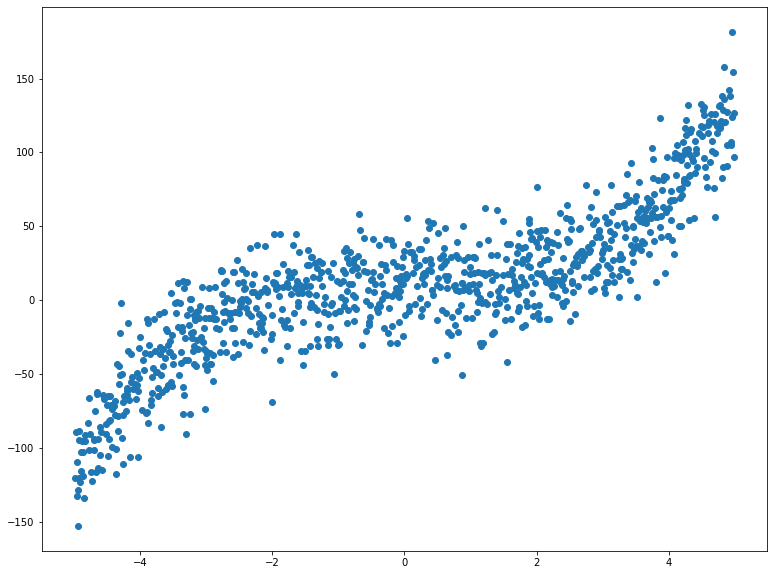

In [272]:
plt.figure(figsize = (13,10))
plt.scatter(X['train'], y['train']);

In [273]:
# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
task_type = "regression"
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}

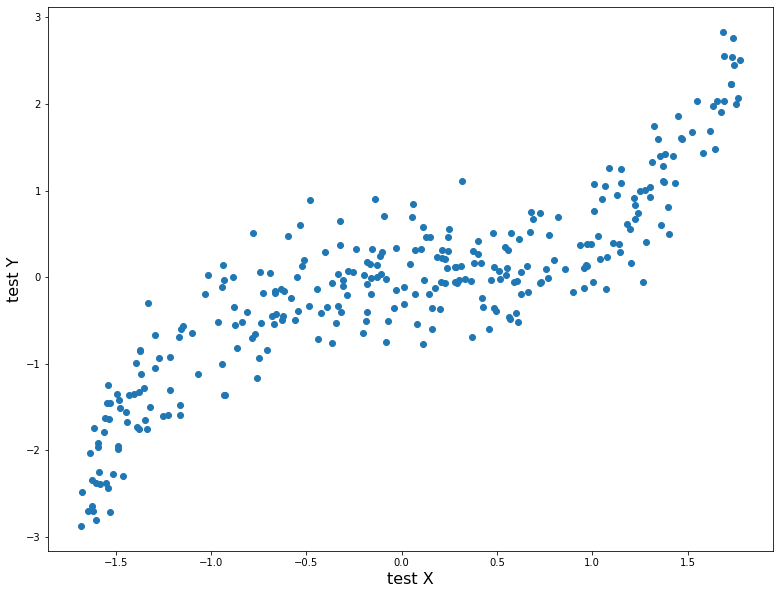

In [274]:
plt.figure(figsize = (13,10))
plt.xlabel("test X", fontsize = 16)
plt.ylabel("test Y", fontsize = 16)
plt.scatter(X['test'], y['test']);

In [275]:
d_out = 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_all.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

# model = rtdl.ResNet.make_baseline(
#     d_in=X_all.shape[1],
#     d_main=128,
#     d_intermidiate=256,
#     dropout_first=0.2,
#     dropout_second=0.0,
#     n_blocks=2,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.FTTransformer.make_default(
    n_num_features=X_all.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=d_out,
)

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [276]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        model.train()
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 32):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 128
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 55.8068


In [277]:
n_epochs = 20
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

(epoch) 1 (batch) 0 (loss) 0.8755
(epoch) 1 (batch) 1 (loss) 0.6633
(epoch) 1 (batch) 2 (loss) 0.5584
(epoch) 1 (batch) 3 (loss) 0.4465
(epoch) 1 (batch) 4 (loss) 0.4752
(epoch) 1 (batch) 5 (loss) 0.4871
(epoch) 1 (batch) 6 (loss) 0.4248
(epoch) 1 (batch) 7 (loss) 0.3820
Epoch 001 | Validation score: 29.2779 | Test score: 32.2650 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.3395
(epoch) 2 (batch) 1 (loss) 0.3710
(epoch) 2 (batch) 2 (loss) 0.3718
(epoch) 2 (batch) 3 (loss) 0.3578
(epoch) 2 (batch) 4 (loss) 0.3485
(epoch) 2 (batch) 5 (loss) 0.3102
(epoch) 2 (batch) 6 (loss) 0.2379
(epoch) 2 (batch) 7 (loss) 0.2658
Epoch 002 | Validation score: 26.1074 | Test score: 28.2956 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.2710
(epoch) 3 (batch) 1 (loss) 0.3396
(epoch) 3 (batch) 2 (loss) 0.3019
(epoch) 3 (batch) 3 (loss) 0.2197
(epoch) 3 (batch) 4 (loss) 0.2740
(epoch) 3 (batch) 5 (loss) 0.3134
(epoch) 3 (batch) 6 (loss) 0.2133
(epoch) 3 (batch) 7 (loss) 0.1832
Epoch 003 | 

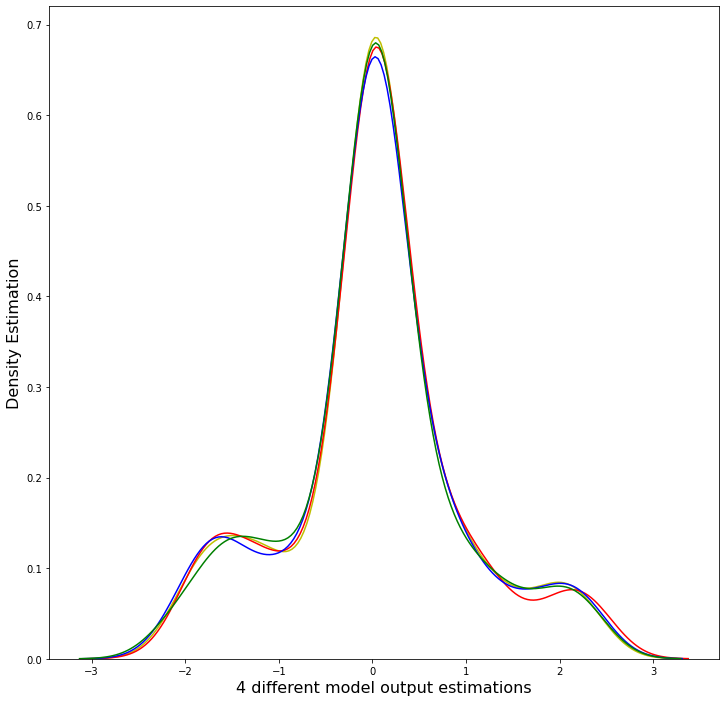

In [278]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,12))

plt.ylabel("Density Estimation", fontsize = 16)
plt.xlabel("4 different model output estimations", fontsize = 16)
sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='y')
sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='r')
sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='b')
sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='g');

In [279]:
from scipy.stats import norm

def gaussian_entropy(sigma: float) -> float:
        return 0.5*np.log(np.exp(1)*2*np.pi*sigma**2)  
    
    
def entropy_estimate_transformer(number_of_samples: int, data: np.ndarray, seed: int) -> float:
    
    
    rng = np.random.default_rng(2021)
    rng.random(seed)
    
    a = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    b = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    c = np.concatenate((a, b), axis=0)

    for i in range(number_of_samples-2):
        d = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
        c = np.concatenate((c, d), axis=0)

    sigmas = []
    for i in range(c.shape[1]):
        sigmas.append(norm.fit(c[:,i])[1])

    entropies = []
    for sigma in sigmas:
        entropies.append(gaussian_entropy(sigma))

    total_entropy = np.mean(entropies)
    
    return total_entropy

In [280]:
entropy_estimate_transformer(number_of_samples = 5, data = X['test'], seed = 13)

-1.2727281740646423

In [281]:

number_of_samples = 100
data = X['test']

a = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
b = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
c = np.concatenate((a, b), axis=0)

for i in range(number_of_samples-2):
    d = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    c = np.concatenate((c, d), axis=0)

sigmas = []
for i in range(c.shape[1]):
    sigmas.append(norm.fit(c[:,i])[1])

entropies = []
for sigma in sigmas:
    entropies.append(gaussian_entropy(sigma))

total_entropy = np.mean(entropies)

In [282]:
len(X['test'])

300

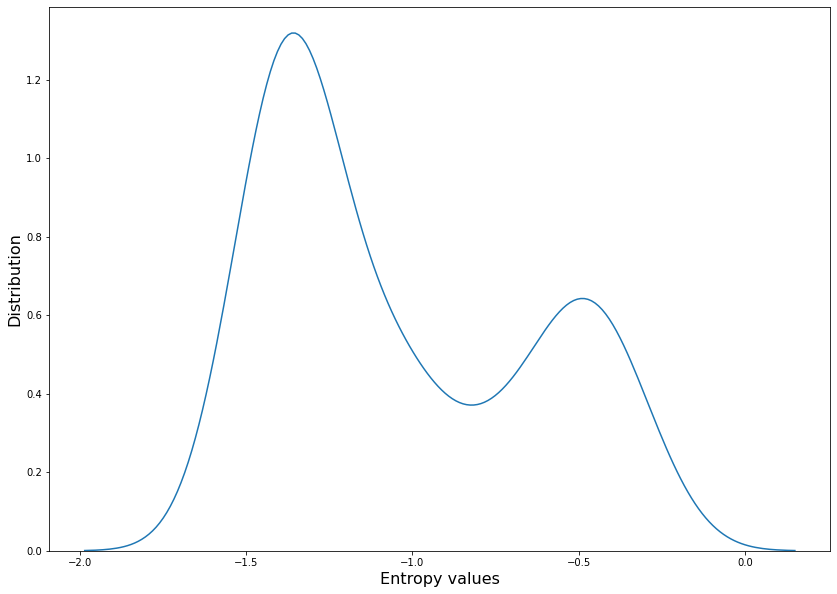

In [283]:
plt.figure(figsize = (14,10))
plt.xlabel("Entropy values", fontsize = 16)
plt.ylabel("Distribution", fontsize = 16)
sns.kdeplot(entropies);

<AxesSubplot:ylabel='Density'>

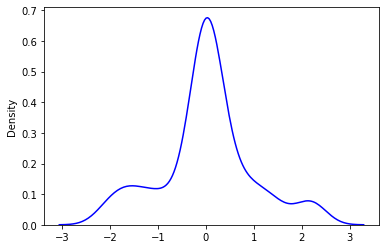

In [284]:
sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='b')

<AxesSubplot:ylabel='Density'>

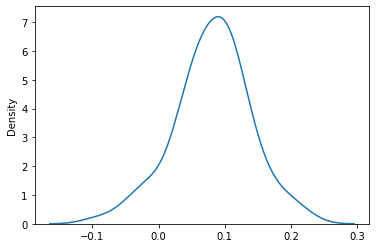

In [285]:
sns.kdeplot(c[:,0])

In [286]:
norm.fit(c[:,0])

(0.08106631, 0.057700045)

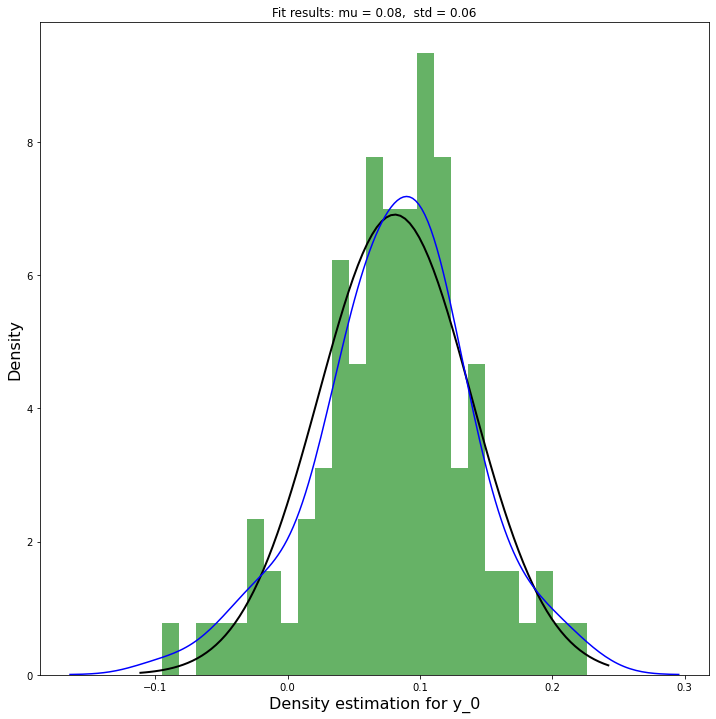

In [287]:
# Generate some data for this demonstration.
plt.figure(figsize = (12,12))

data = c[:,0]

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.ylabel("Density", fontsize = 16)
plt.xlabel("Density estimation for y_0", fontsize = 16)
plt.plot(x, p, 'k', linewidth=2)
sns.kdeplot(c[:,0], color='b')
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [288]:
print(0.5*np.log2(2*np.pi*std**2)+0.5)

-2.2895356708443075


# 4 datasets

## 1) Heteroskedastic & continous

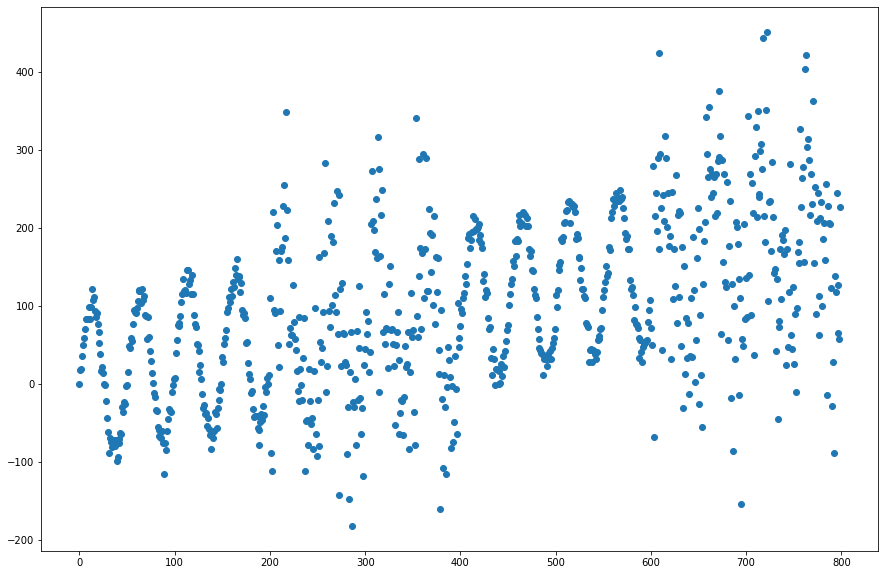

In [289]:
lenght = 200

series_het_and_cont = np.sin(0.125*np.arange(0,lenght*4))*100 + np.random.normal(scale=np.concatenate((np.array([1]*lenght),
                                                                                          np.array([8]*lenght),
                                                                                          np.array([1]*lenght),
                                                                                          np.array([8]*lenght)), axis = None))*10+np.arange(lenght*4)/4
plt.figure(figsize = (15,10)) 
X_1 = np.arange(0, lenght*4)
y_1 = series_het_and_cont
plt.scatter(X_1, y_1);


## 2) Gomoskedastic & continous

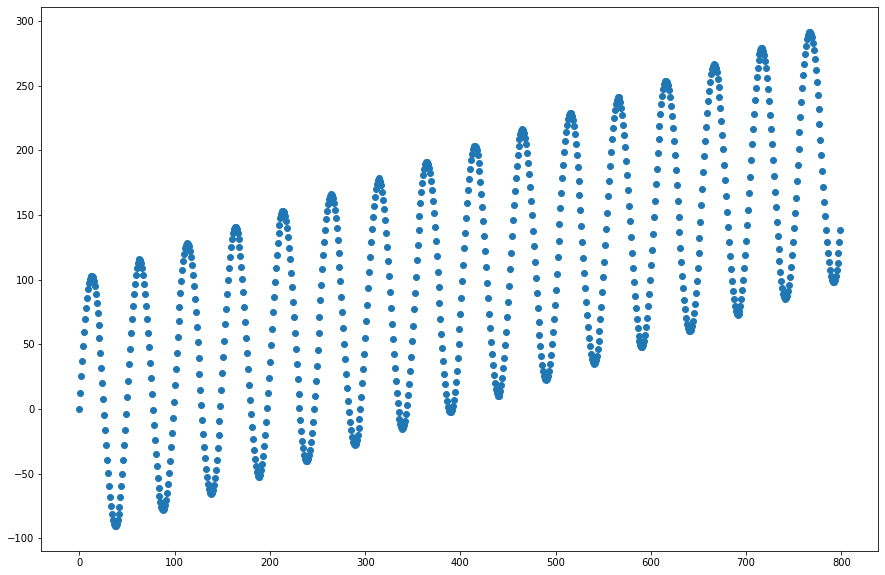

In [290]:
series_gom_and_cont =  np.sin(0.125*np.arange(0,lenght*4))*100 + np.arange(lenght*4)/4

plt.figure(figsize = (15,10)) 
X_2 = np.arange(0, lenght*4)
y_2 = series_gom_and_cont
plt.scatter(X_2, y_2);


## 3) Heteroskedastic & discontinous

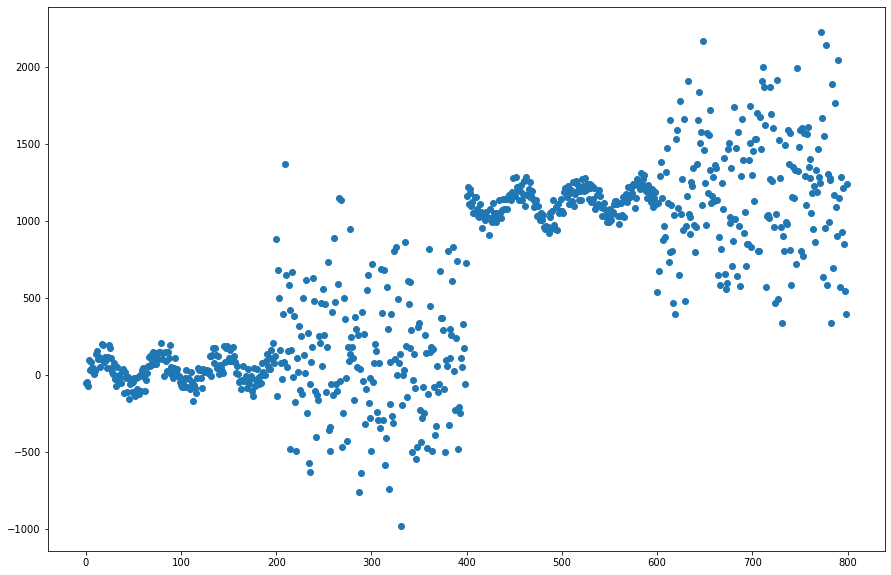

In [291]:
a = [0]*(lenght*2)
b = [1000]*(lenght*2)
c = np.concatenate((a,b))
c


series_het_and_discont = np.sin(0.1*np.arange(0,lenght*4))*100 + np.random.normal(scale=np.concatenate((np.array([1]*lenght),
                                                                                          np.array([8]*lenght),
                                                                                          np.array([1]*lenght),
                                                                                          np.array([8]*lenght)), axis = None))*50 + np.arange(lenght*4)/4 + c


plt.figure(figsize = (15,10)) 
X_3 = np.arange(0, lenght*4)
y_3 = series_het_and_discont
plt.scatter(X_3, y_3);



## 4) Gomoskedastic and discontinuous

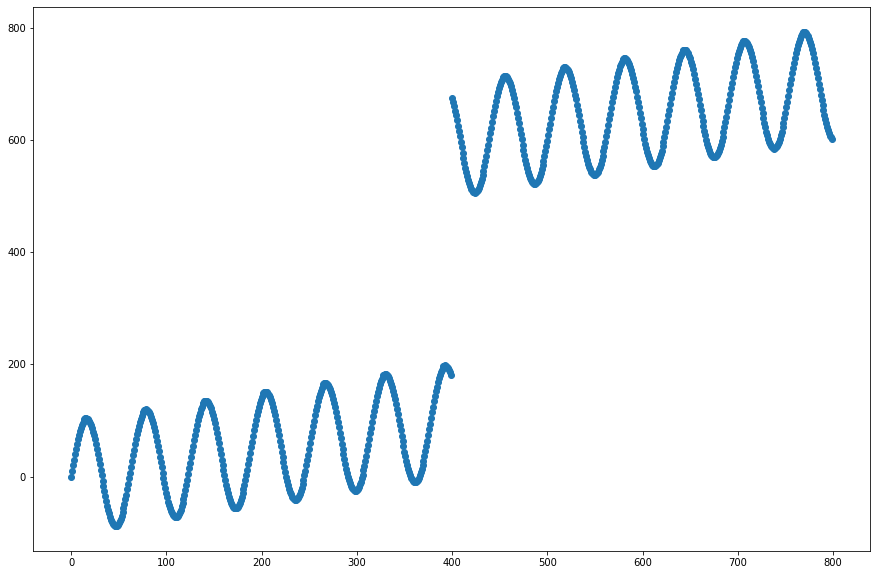

In [292]:
series_gom_and_discont = np.sin(0.1*np.arange(0,lenght*4))*100 + np.arange(lenght*4)/4 + c/2


plt.figure(figsize = (15,10)) 
X_4 = np.arange(0, lenght*4)
y_4 = series_gom_and_discont
plt.scatter(X_4, y_4);



# Test Uncertainty on artificial datasets

### 1) UE on Heteroskedastic & continous

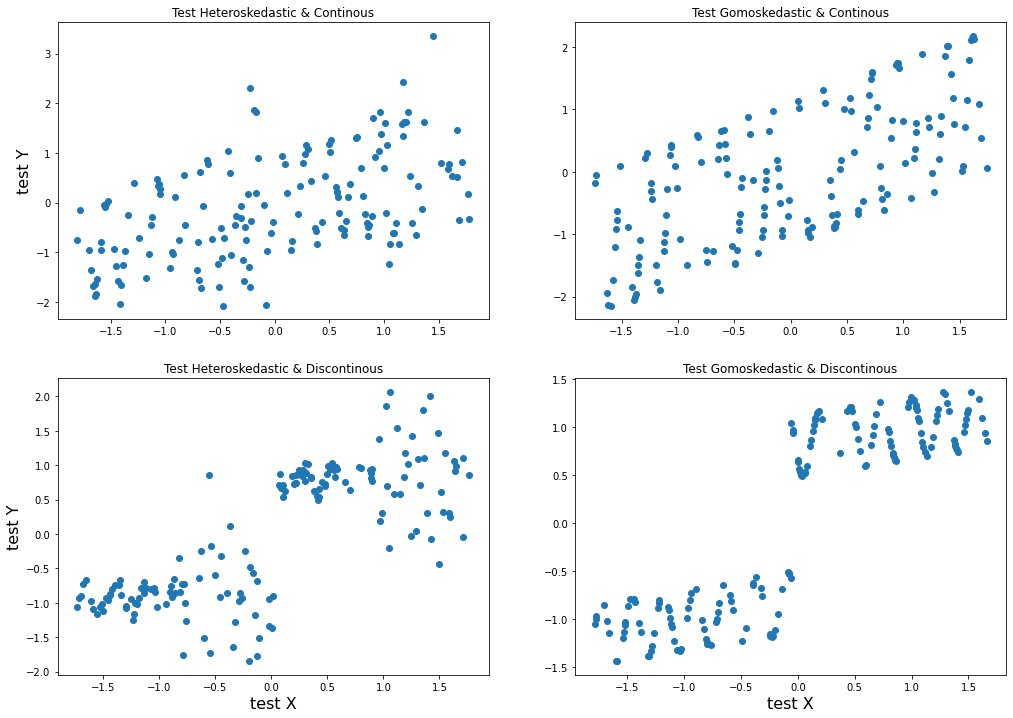

In [293]:
def data_preprocess(input_X, input_y, task_type = "regression"):
    
    input_X=list(input_X)
    input_X = np.array([[i] for i in input_X], dtype = np.float32)
    
    X = {}
    y = {}
    
    X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
        input_X, input_y, train_size=0.8
    )
    X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
        X['train'], y['train'], train_size=0.8
    )

    # not the best way to preprocess features, but enough for the demonstration
    preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
    
    X = {
        k: torch.tensor(preprocess.fit_transform(v), device=device)
        for k, v in X.items()
    }
    y = {k: torch.tensor(v, device=device) for k, v in y.items()}

    # !!! CRUCIAL for neural networks when solving regression problems !!!
    if task_type == 'regression':
        y_mean = y['train'].mean().item()
        y_std = y['train'].std().item()
        y = {k: (v - y_mean) / y_std for k, v in y.items()}
    else:
        y_std = y_mean = None

    if task_type != 'multiclass':
        y = {k: v.float() for k, v in y.items()}
    
    return X, y


X_h_c, y_h_c = data_preprocess(X_1, y_1)
X_g_c, y_g_c = data_preprocess(X_2, y_2)
X_h_d, y_h_d = data_preprocess(X_3, y_3)
X_g_d, y_g_d = data_preprocess(X_4, y_4)




# plot prepared test data
plt.figure(figsize = (17,12))


plt.subplot(2, 2, 1)
plt.ylabel("test Y", fontsize = 16)
plt.scatter(X_h_c['test'], y_h_c['test'])
plt.title("Test Heteroskedastic & Continous")

plt.subplot(2, 2, 2)
plt.scatter(X_g_c['test'], y_g_c['test'])
plt.title("Test Gomoskedastic & Continous")

plt.subplot(2, 2, 3)
plt.xlabel("test X", fontsize = 16)
plt.ylabel("test Y", fontsize = 16)
plt.scatter(X_h_d['test'], y_h_d['test'])
plt.title("Test Heteroskedastic & Discontinous")

plt.subplot(2, 2, 4)
plt.xlabel("test X", fontsize = 16)
plt.scatter(X_g_d['test'], y_g_d['test'])
plt.title("Test Gomoskedastic & Discontinous");


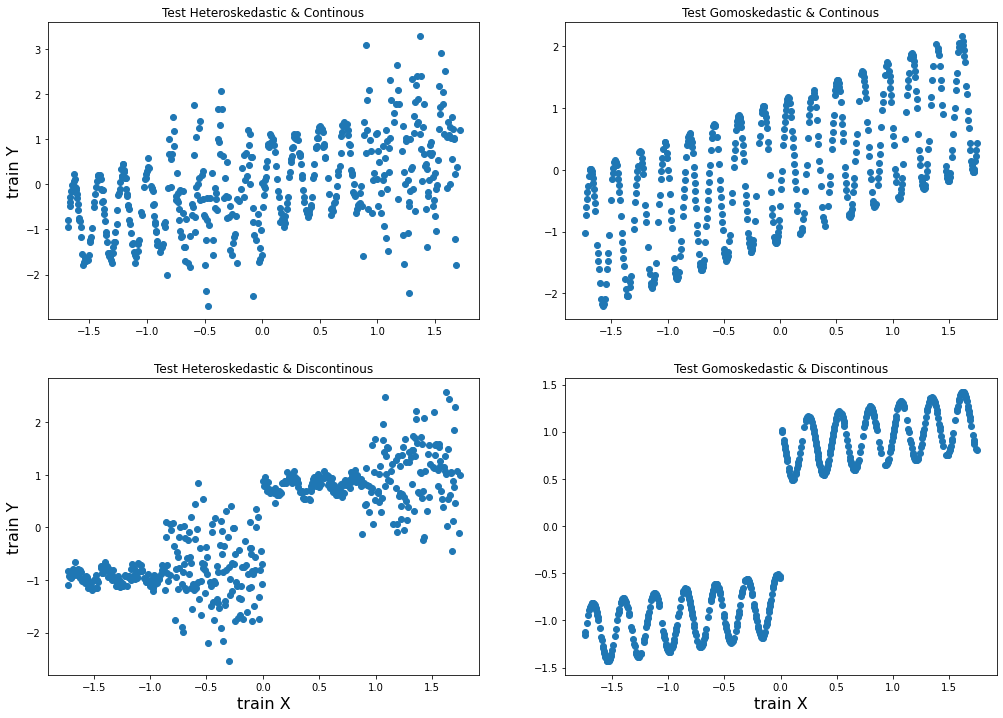

In [294]:
# plot prepared test data
plt.figure(figsize = (17,12))


plt.subplot(2, 2, 1)
plt.xlabel("train X", fontsize = 16)
plt.ylabel("train Y", fontsize = 16)
plt.scatter(X_h_c['train'], y_h_c['train'])
plt.xlabel('')
plt.title("Test Heteroskedastic & Continous")

plt.subplot(2, 2, 2)
plt.scatter(X_g_c['train'], y_g_c['train'])
plt.title("Test Gomoskedastic & Continous")

plt.subplot(2, 2, 3)
plt.xlabel("train X", fontsize = 16)
plt.ylabel("train Y", fontsize = 16)
plt.scatter(X_h_d['train'], y_h_d['train'])
plt.title("Test Heteroskedastic & Discontinous")

plt.subplot(2, 2, 4)
plt.xlabel("train X", fontsize = 16)
plt.scatter(X_g_d['train'], y_g_d['train'])
plt.title("Test Gomoskedastic & Discontinous");


# Model application and UE

In [308]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def model_application_and_UE(X, y,
                             d_out = 1, 
                             lr = 0.001, 
                             weight_decay = 0.0,
                             n_epochs = 5000,
                             entropy_number_of_samples = 5,
                             batch_size = 20,
                             seed = 13):
    
    
    model = rtdl.FTTransformer.make_default(
        n_num_features=X['train'].size()[1],
        cat_cardinalities=None,
        last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
        d_out=d_out,
    )

    model.to(device)
    optimizer = (
        model.make_default_optimizer()
        if isinstance(model, rtdl.FTTransformer)
        else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    )

    loss_fn = (
        F.binary_cross_entropy_with_logits
        if task_type == 'binclass'
        else F.cross_entropy
        if task_type == 'multiclass'
        else F.mse_loss
    )

    # Create a dataloader for batches of indices
    # Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
    train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

    # Create a progress tracker for early stopping
    # Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
    progress = zero.ProgressTracker(patience=100)

    
    print(f'Test score before training: {evaluate("test"):.4f}')
    print("###################################################")
    
    
    report_frequency = len(X['train']) // 5
    for epoch in range(1, n_epochs + 1):
        for iteration, batch_idx in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            x_batch = X['train'][batch_idx]
            y_batch = y['train'][batch_idx]
            loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
            loss.backward()
            optimizer.step()
            if iteration % report_frequency == 0:
                print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate('val')
        test_score = evaluate('test')
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
        progress.update((-1 if task_type == 'regression' else 1) * val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH', end='')
        print()
        if progress.fail:
            break
            
    plt.figure(figsize = (12,12))

    plt.ylabel("Density Estimation", fontsize = 16)
    plt.xlabel("10 different model output estimations", fontsize = 16)
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='y')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='r')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='b')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy(), color='g')
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    sns.kdeplot(apply_model(X['test']).reshape(-1).detach().numpy())
    plt.show();
    
    plt.figure(figsize = (12,12))
    plt.title("Actual y test distribution")
    sns.kdeplot(y['test']);
    
    test_entropy = entropy_estimate_transformer(number_of_samples = entropy_number_of_samples,
                                                data = X['test'],
                                                seed = seed)
    
    
    data = X['test']

    a = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    b = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
    c = np.concatenate((a, b), axis=0)

    for i in range(number_of_samples-2):
        d = np.array([apply_model(data).view(-1,1).to(device).reshape(-1).detach().numpy()])
        c = np.concatenate((c, d), axis=0)

    sigmas = []
    for i in range(c.shape[1]):
        sigmas.append(norm.fit(c[:,i])[1])

    entropies = []
    for sigma in sigmas:
        entropies.append(gaussian_entropy(sigma))

    total_entropy = np.mean(entropies)
    
    print("the overall entropy is {}".format(total_entropy))
    
    plt.figure(figsize = (14,10))
    plt.xlabel("Entropy values", fontsize = 16)
    plt.ylabel("Distribution", fontsize = 16)
    sns.kdeplot(entropies)
    plt.show();
    
    plt.xlabel("X", fontsize = 16)
    plt.ylabel("Y", fontsize = 16)
    plt.scatter(X['test'], y['test'])
    plt.title("{}".format(namestr(X, globals())))

Test score before training: 21.9455
###################################################
(epoch) 1 (batch) 0 (loss) 1.3574
Epoch 001 | Validation score: 22.2611 | Test score: 21.9566 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 1.3984
Epoch 002 | Validation score: 21.4282 | Test score: 22.4619 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 1.3555
Epoch 003 | Validation score: 21.3182 | Test score: 22.2608 <<< BEST VALIDATION EPOCH
(epoch) 4 (batch) 0 (loss) 1.2388
Epoch 004 | Validation score: 22.5511 | Test score: 21.2790
(epoch) 5 (batch) 0 (loss) 1.2971
Epoch 005 | Validation score: 22.1954 | Test score: 21.4532
(epoch) 6 (batch) 0 (loss) 1.2717
Epoch 006 | Validation score: 21.4442 | Test score: 22.3271
(epoch) 7 (batch) 0 (loss) 1.3592
Epoch 007 | Validation score: 21.5352 | Test score: 22.4291
(epoch) 8 (batch) 0 (loss) 1.3467
Epoch 008 | Validation score: 22.1225 | Test score: 21.9796
(epoch) 9 (batch) 0 (loss) 1.3193
Epoch 009 | Validation score: 22.1608 | Test sco

Epoch 085 | Validation score: 22.1938 | Test score: 21.6733
(epoch) 86 (batch) 0 (loss) 1.1379
Epoch 086 | Validation score: 21.9811 | Test score: 21.7895
(epoch) 87 (batch) 0 (loss) 1.3853
Epoch 087 | Validation score: 22.2116 | Test score: 21.8971
(epoch) 88 (batch) 0 (loss) 1.3637
Epoch 088 | Validation score: 22.3351 | Test score: 21.8863
(epoch) 89 (batch) 0 (loss) 1.3105
Epoch 089 | Validation score: 21.8546 | Test score: 22.0219
(epoch) 90 (batch) 0 (loss) 1.3605
Epoch 090 | Validation score: 21.9810 | Test score: 22.1641
(epoch) 91 (batch) 0 (loss) 1.3147
Epoch 091 | Validation score: 22.2228 | Test score: 22.3490
(epoch) 92 (batch) 0 (loss) 1.2881
Epoch 092 | Validation score: 21.7604 | Test score: 21.3248
(epoch) 93 (batch) 0 (loss) 1.3521
Epoch 093 | Validation score: 21.6534 | Test score: 22.3086
(epoch) 94 (batch) 0 (loss) 1.2350
Epoch 094 | Validation score: 21.7752 | Test score: 21.4161
(epoch) 95 (batch) 0 (loss) 1.3214
Epoch 095 | Validation score: 22.1019 | Test score

Epoch 171 | Validation score: 21.3074 | Test score: 22.2722
(epoch) 172 (batch) 0 (loss) 1.2190
Epoch 172 | Validation score: 21.2548 | Test score: 22.1856
(epoch) 173 (batch) 0 (loss) 1.3805
Epoch 173 | Validation score: 21.3626 | Test score: 21.8215
(epoch) 174 (batch) 0 (loss) 1.3877
Epoch 174 | Validation score: 21.3291 | Test score: 22.0245
(epoch) 175 (batch) 0 (loss) 1.3091
Epoch 175 | Validation score: 21.9274 | Test score: 22.6097
(epoch) 176 (batch) 0 (loss) 1.3172
Epoch 176 | Validation score: 21.6325 | Test score: 21.9199


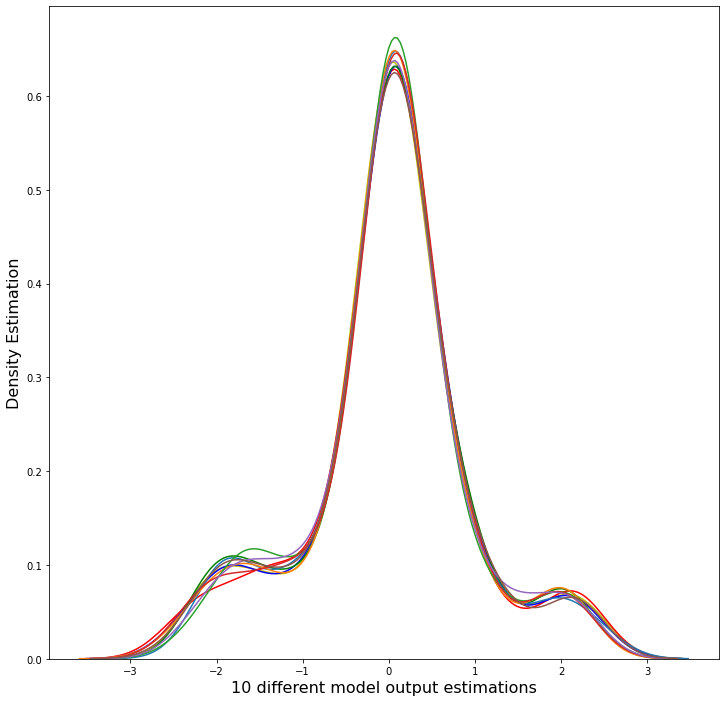

the overall entropy is -1.0444870887834639


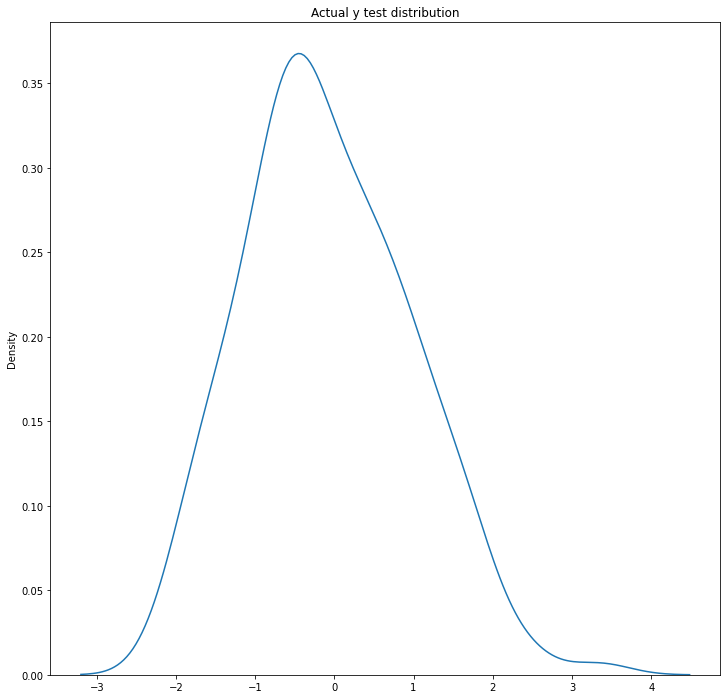

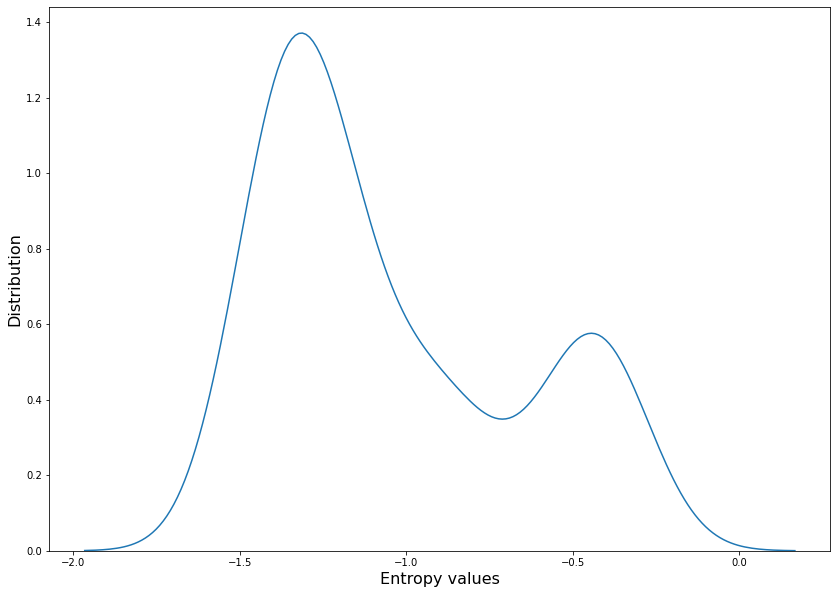

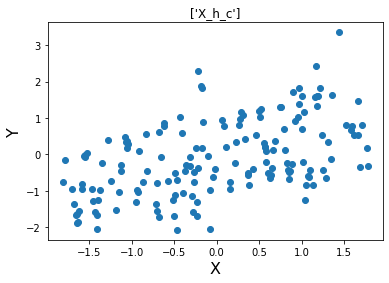

In [309]:
model_application_and_UE(X_h_c, y_h_c)

Test score before training: 21.3832
###################################################
(epoch) 1 (batch) 0 (loss) 1.1959
Epoch 001 | Validation score: 21.4493 | Test score: 21.7492 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 1.1930
Epoch 002 | Validation score: 21.9503 | Test score: 21.6429
(epoch) 3 (batch) 0 (loss) 1.3020
Epoch 003 | Validation score: 22.0800 | Test score: 22.0502
(epoch) 4 (batch) 0 (loss) 1.1039
Epoch 004 | Validation score: 21.9219 | Test score: 21.6158
(epoch) 5 (batch) 0 (loss) 1.2389
Epoch 005 | Validation score: 22.0157 | Test score: 22.2525
(epoch) 6 (batch) 0 (loss) 1.1264
Epoch 006 | Validation score: 22.2225 | Test score: 22.3250
(epoch) 7 (batch) 0 (loss) 1.1717
Epoch 007 | Validation score: 21.8089 | Test score: 21.6379
(epoch) 8 (batch) 0 (loss) 1.1292
Epoch 008 | Validation score: 21.3279 | Test score: 22.0569 <<< BEST VALIDATION EPOCH
(epoch) 9 (batch) 0 (loss) 1.2343
Epoch 009 | Validation score: 22.1572 | Test score: 22.2778
(epoch) 10 (ba

Epoch 085 | Validation score: 21.9014 | Test score: 22.2414
(epoch) 86 (batch) 0 (loss) 1.1657
Epoch 086 | Validation score: 21.7965 | Test score: 22.3750
(epoch) 87 (batch) 0 (loss) 1.1769
Epoch 087 | Validation score: 21.5669 | Test score: 22.2815
(epoch) 88 (batch) 0 (loss) 1.1759
Epoch 088 | Validation score: 21.7372 | Test score: 22.4777
(epoch) 89 (batch) 0 (loss) 1.2457
Epoch 089 | Validation score: 21.9306 | Test score: 22.3054
(epoch) 90 (batch) 0 (loss) 1.1893
Epoch 090 | Validation score: 22.0110 | Test score: 22.0997
(epoch) 91 (batch) 0 (loss) 1.2160
Epoch 091 | Validation score: 22.1535 | Test score: 22.4588
(epoch) 92 (batch) 0 (loss) 1.1690
Epoch 092 | Validation score: 21.9388 | Test score: 21.8531
(epoch) 93 (batch) 0 (loss) 1.2084
Epoch 093 | Validation score: 21.7104 | Test score: 22.0027
(epoch) 94 (batch) 0 (loss) 1.0723
Epoch 094 | Validation score: 21.7028 | Test score: 22.3205
(epoch) 95 (batch) 0 (loss) 1.1406
Epoch 095 | Validation score: 21.1442 | Test score

Epoch 171 | Validation score: 21.8602 | Test score: 22.1773
(epoch) 172 (batch) 0 (loss) 1.2211
Epoch 172 | Validation score: 22.4203 | Test score: 22.3450
(epoch) 173 (batch) 0 (loss) 1.1727
Epoch 173 | Validation score: 21.5951 | Test score: 22.3199
(epoch) 174 (batch) 0 (loss) 1.1253
Epoch 174 | Validation score: 21.8554 | Test score: 21.9098
(epoch) 175 (batch) 0 (loss) 1.0861
Epoch 175 | Validation score: 21.5960 | Test score: 22.0930
(epoch) 176 (batch) 0 (loss) 1.1455
Epoch 176 | Validation score: 22.0369 | Test score: 21.7541
(epoch) 177 (batch) 0 (loss) 1.2610
Epoch 177 | Validation score: 21.6702 | Test score: 21.8907
(epoch) 178 (batch) 0 (loss) 1.1180
Epoch 178 | Validation score: 21.6725 | Test score: 22.3384
(epoch) 179 (batch) 0 (loss) 1.1491
Epoch 179 | Validation score: 22.1314 | Test score: 22.3496
(epoch) 180 (batch) 0 (loss) 1.1780
Epoch 180 | Validation score: 21.8842 | Test score: 21.8607
(epoch) 181 (batch) 0 (loss) 1.1678
Epoch 181 | Validation score: 21.5583 | 

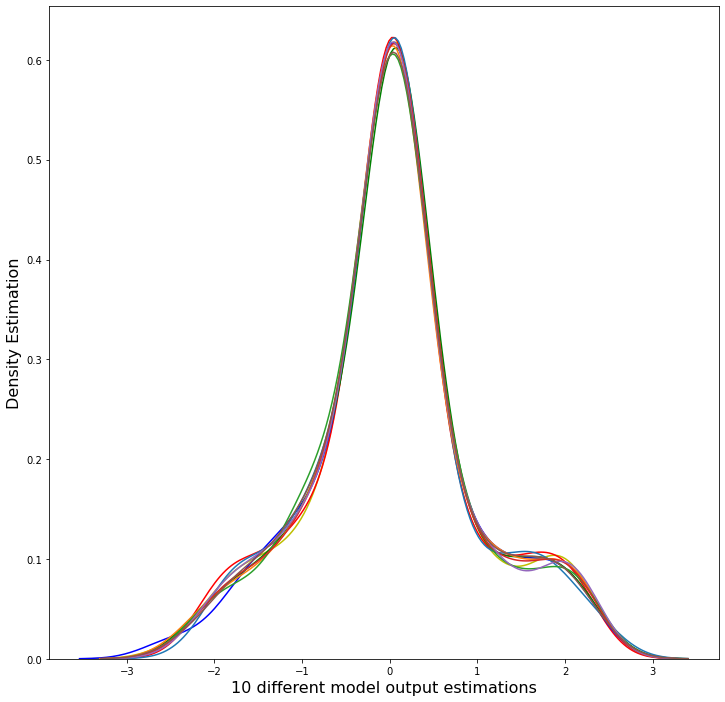

the overall entropy is -1.045561822522438


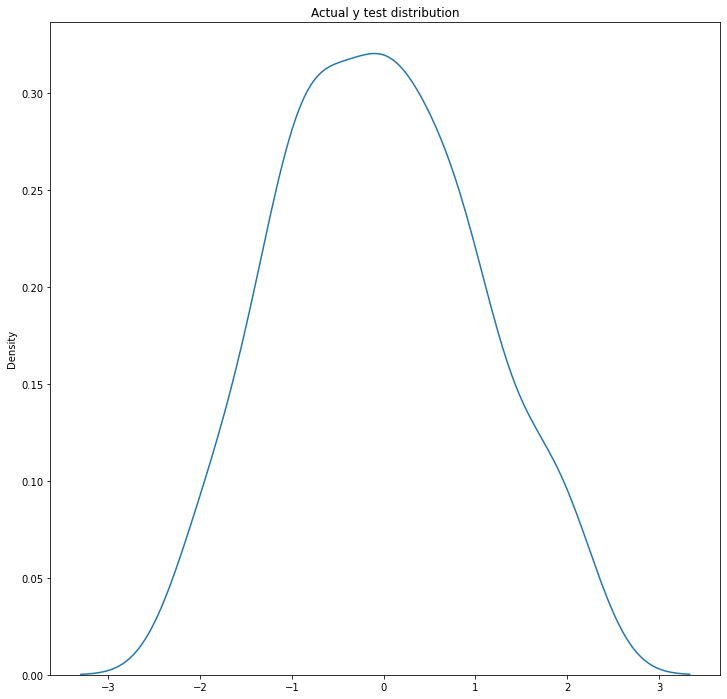

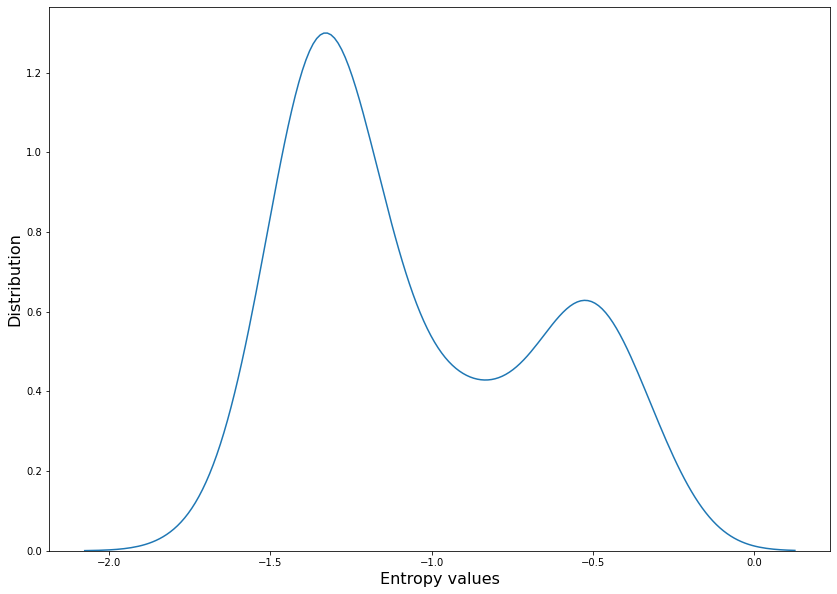

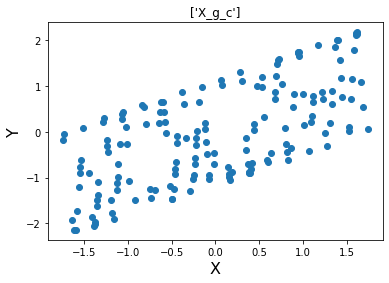

In [310]:
model_application_and_UE(X_g_c, y_g_c)

Test score before training: 22.0519
###################################################
(epoch) 1 (batch) 0 (loss) 0.4113
Epoch 001 | Validation score: 22.2812 | Test score: 21.8748 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.4187
Epoch 002 | Validation score: 21.7814 | Test score: 22.3820 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.4279
Epoch 003 | Validation score: 22.1509 | Test score: 21.9736
(epoch) 4 (batch) 0 (loss) 0.4048
Epoch 004 | Validation score: 21.5191 | Test score: 21.8524 <<< BEST VALIDATION EPOCH
(epoch) 5 (batch) 0 (loss) 0.4189
Epoch 005 | Validation score: 22.1311 | Test score: 22.3049
(epoch) 6 (batch) 0 (loss) 0.4403
Epoch 006 | Validation score: 22.8147 | Test score: 21.9166
(epoch) 7 (batch) 0 (loss) 0.4104
Epoch 007 | Validation score: 21.8329 | Test score: 22.2932
(epoch) 8 (batch) 0 (loss) 0.4128
Epoch 008 | Validation score: 21.9059 | Test score: 22.3132
(epoch) 9 (batch) 0 (loss) 0.4420
Epoch 009 | Validation score: 21.6614 | Test sco

Epoch 085 | Validation score: 21.8244 | Test score: 22.3528
(epoch) 86 (batch) 0 (loss) 0.4334
Epoch 086 | Validation score: 22.4839 | Test score: 22.1452
(epoch) 87 (batch) 0 (loss) 0.4104
Epoch 087 | Validation score: 22.2183 | Test score: 22.0632
(epoch) 88 (batch) 0 (loss) 0.4417
Epoch 088 | Validation score: 22.0420 | Test score: 22.0612
(epoch) 89 (batch) 0 (loss) 0.4307
Epoch 089 | Validation score: 22.0223 | Test score: 21.7059
(epoch) 90 (batch) 0 (loss) 0.4493
Epoch 090 | Validation score: 21.4682 | Test score: 21.8111
(epoch) 91 (batch) 0 (loss) 0.4682
Epoch 091 | Validation score: 21.6977 | Test score: 21.9243
(epoch) 92 (batch) 0 (loss) 0.3831
Epoch 092 | Validation score: 21.3706 | Test score: 21.7950
(epoch) 93 (batch) 0 (loss) 0.4067
Epoch 093 | Validation score: 22.2866 | Test score: 21.9504
(epoch) 94 (batch) 0 (loss) 0.4447
Epoch 094 | Validation score: 22.4471 | Test score: 21.9307
(epoch) 95 (batch) 0 (loss) 0.4025
Epoch 095 | Validation score: 22.1356 | Test score

Epoch 171 | Validation score: 21.9125 | Test score: 22.0642
(epoch) 172 (batch) 0 (loss) 0.4234
Epoch 172 | Validation score: 21.8742 | Test score: 22.0115
(epoch) 173 (batch) 0 (loss) 0.4951
Epoch 173 | Validation score: 21.6817 | Test score: 21.6684
(epoch) 174 (batch) 0 (loss) 0.4217
Epoch 174 | Validation score: 21.2280 | Test score: 22.0860
(epoch) 175 (batch) 0 (loss) 0.4097
Epoch 175 | Validation score: 21.7845 | Test score: 21.8666
(epoch) 176 (batch) 0 (loss) 0.4254
Epoch 176 | Validation score: 21.8749 | Test score: 22.2640
(epoch) 177 (batch) 0 (loss) 0.4839
Epoch 177 | Validation score: 21.4350 | Test score: 21.8853
(epoch) 178 (batch) 0 (loss) 0.5084
Epoch 178 | Validation score: 21.4383 | Test score: 21.8416
(epoch) 179 (batch) 0 (loss) 0.4347
Epoch 179 | Validation score: 21.4772 | Test score: 21.4434
(epoch) 180 (batch) 0 (loss) 0.4444
Epoch 180 | Validation score: 21.9882 | Test score: 22.2162
(epoch) 181 (batch) 0 (loss) 0.4731
Epoch 181 | Validation score: 21.5248 | 

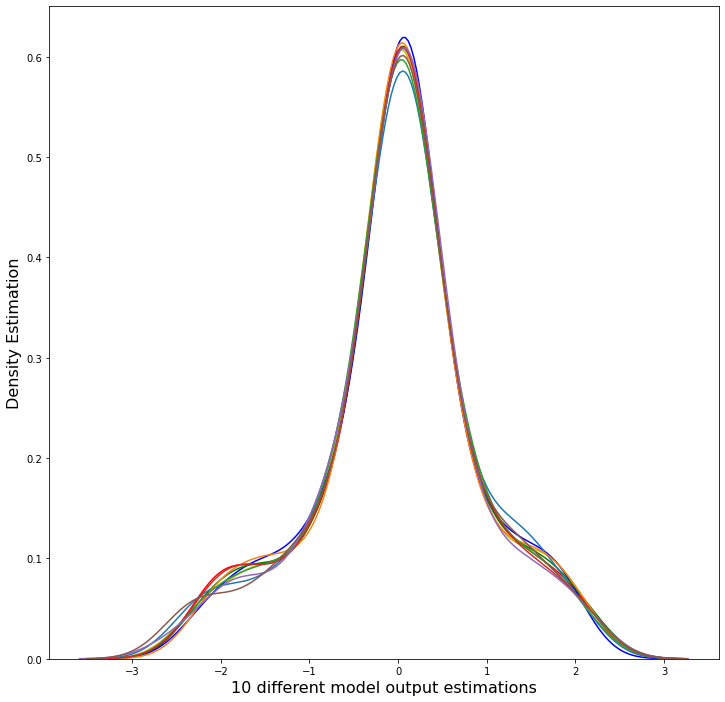

the overall entropy is -1.0489509117324278


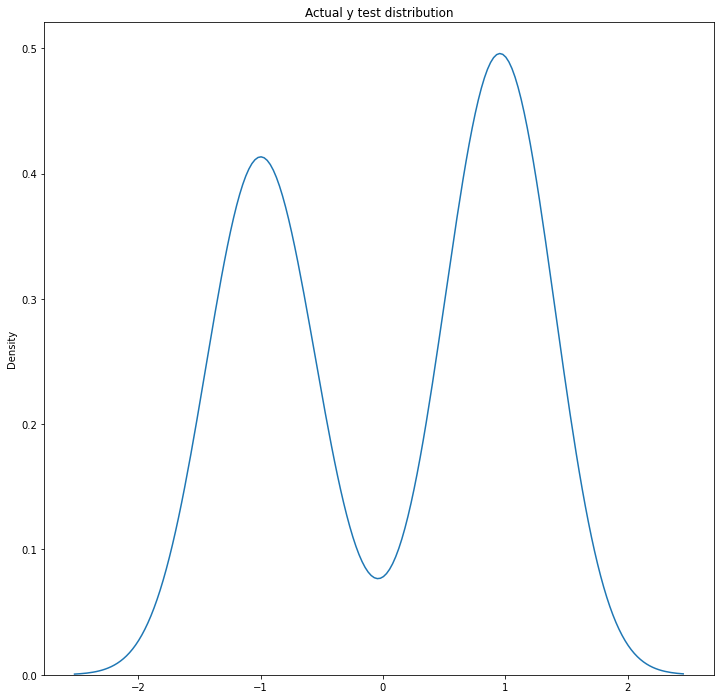

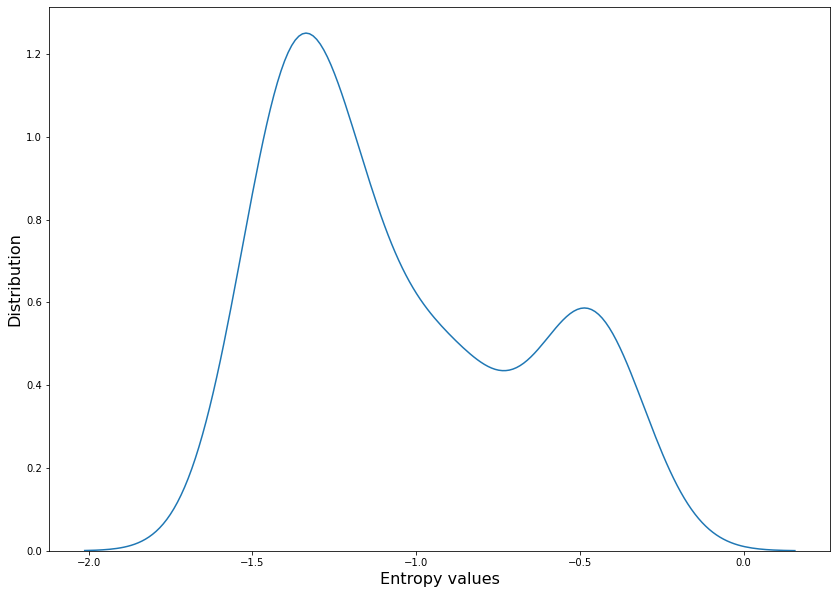

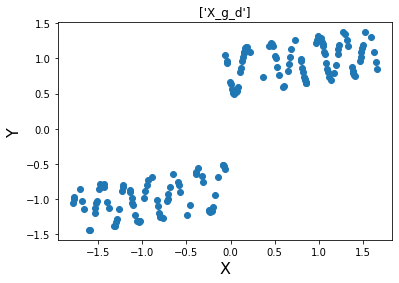

In [311]:
model_application_and_UE(X_g_d, y_g_d)

Test score before training: 21.7067
###################################################
(epoch) 1 (batch) 0 (loss) 0.5505
Epoch 001 | Validation score: 21.9130 | Test score: 22.1014 <<< BEST VALIDATION EPOCH
(epoch) 2 (batch) 0 (loss) 0.5025
Epoch 002 | Validation score: 21.7031 | Test score: 22.1932 <<< BEST VALIDATION EPOCH
(epoch) 3 (batch) 0 (loss) 0.4869
Epoch 003 | Validation score: 22.1224 | Test score: 22.2554
(epoch) 4 (batch) 0 (loss) 0.5180
Epoch 004 | Validation score: 21.5896 | Test score: 21.8785 <<< BEST VALIDATION EPOCH
(epoch) 5 (batch) 0 (loss) 0.5334
Epoch 005 | Validation score: 21.7799 | Test score: 22.2238
(epoch) 6 (batch) 0 (loss) 0.5367
Epoch 006 | Validation score: 21.9799 | Test score: 21.6585
(epoch) 7 (batch) 0 (loss) 0.5453
Epoch 007 | Validation score: 22.1758 | Test score: 21.5890
(epoch) 8 (batch) 0 (loss) 0.5694
Epoch 008 | Validation score: 21.6182 | Test score: 22.4378
(epoch) 9 (batch) 0 (loss) 0.4999
Epoch 009 | Validation score: 22.0219 | Test sco

Epoch 085 | Validation score: 21.7849 | Test score: 21.9117
(epoch) 86 (batch) 0 (loss) 0.5198
Epoch 086 | Validation score: 21.6990 | Test score: 22.4793
(epoch) 87 (batch) 0 (loss) 0.5505
Epoch 087 | Validation score: 21.8351 | Test score: 22.2433
(epoch) 88 (batch) 0 (loss) 0.5439
Epoch 088 | Validation score: 21.5277 | Test score: 21.9917
(epoch) 89 (batch) 0 (loss) 0.5216
Epoch 089 | Validation score: 21.3266 | Test score: 22.3180
(epoch) 90 (batch) 0 (loss) 0.5054
Epoch 090 | Validation score: 21.9306 | Test score: 21.5323
(epoch) 91 (batch) 0 (loss) 0.5485
Epoch 091 | Validation score: 21.9018 | Test score: 22.0242
(epoch) 92 (batch) 0 (loss) 0.5190
Epoch 092 | Validation score: 22.0479 | Test score: 22.0653
(epoch) 93 (batch) 0 (loss) 0.5337
Epoch 093 | Validation score: 22.1238 | Test score: 22.1213
(epoch) 94 (batch) 0 (loss) 0.5707
Epoch 094 | Validation score: 20.9589 | Test score: 22.2283
(epoch) 95 (batch) 0 (loss) 0.5181
Epoch 095 | Validation score: 22.3911 | Test score

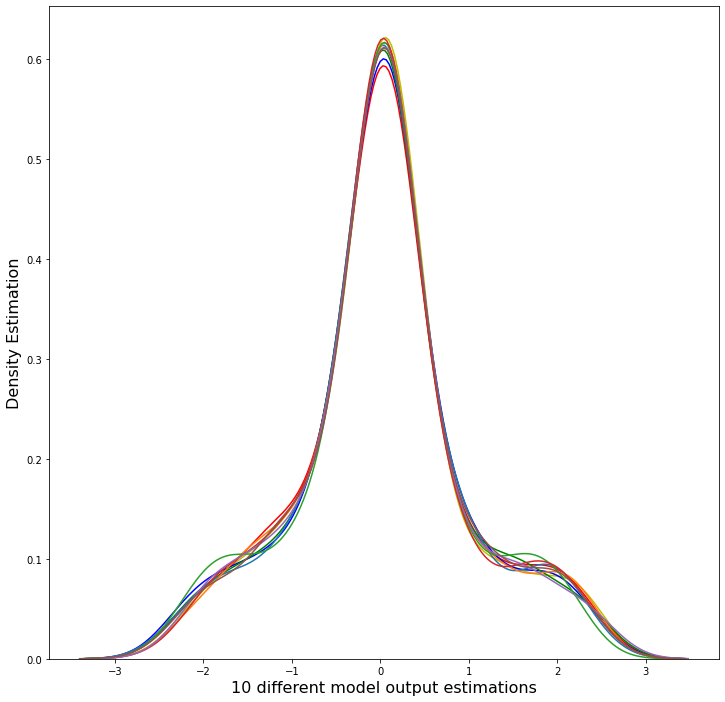

the overall entropy is -1.040313289080604


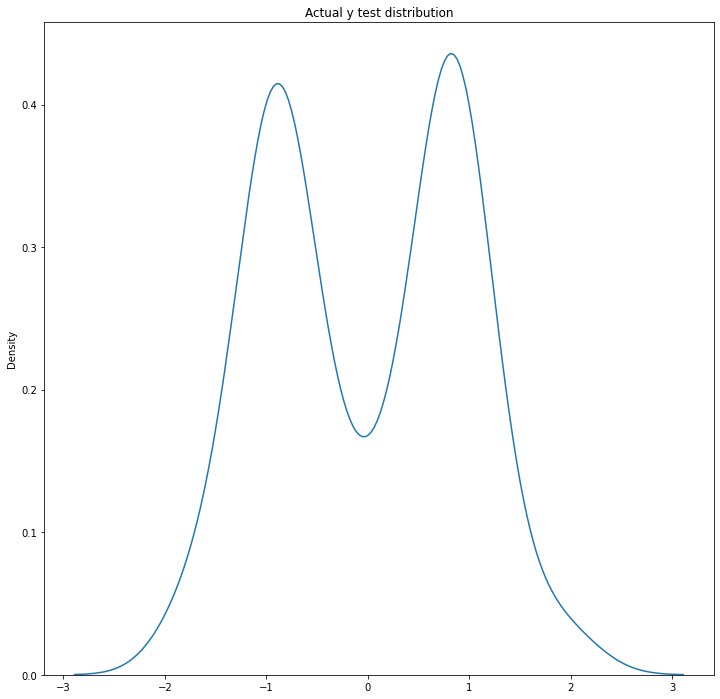

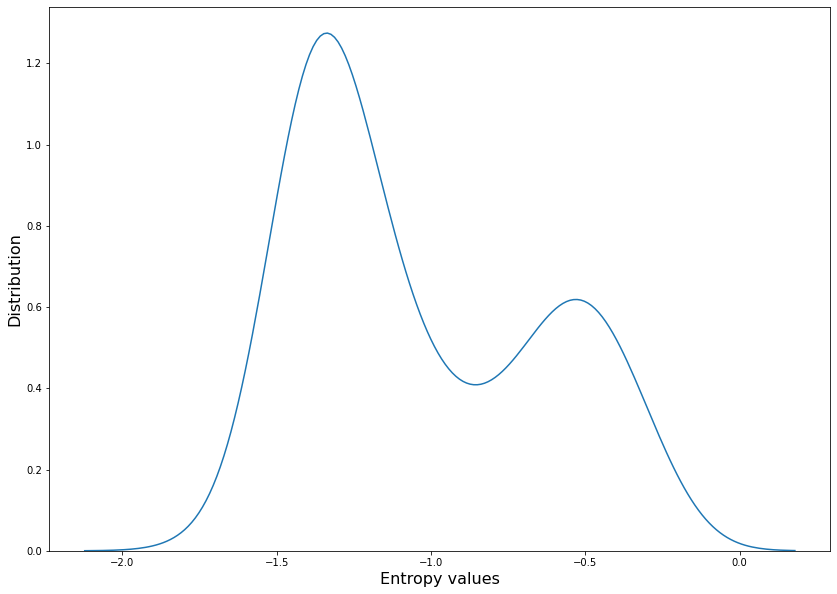

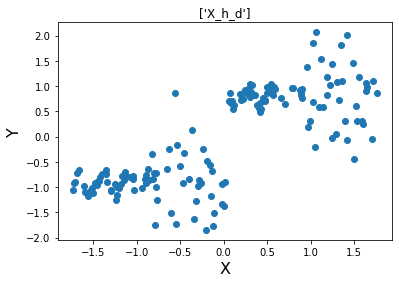

In [312]:
model_application_and_UE(X_h_d, y_h_d)

# Uncertainty, using std

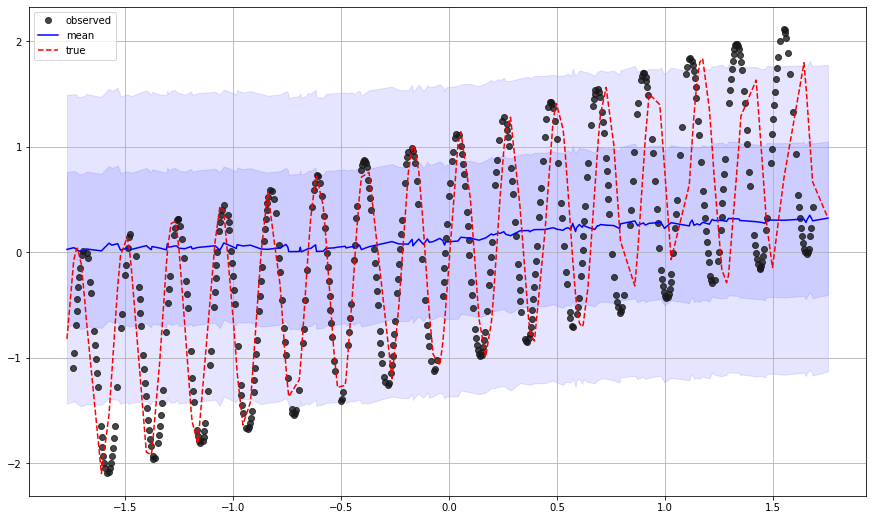

In [225]:
X, y = X_g_c, y_g_c


X['train'], y['train'] = zip(*sorted(zip(X['train'], y['train'])))
X['val'], y['val'] = zip(*sorted(zip(X['val'], y['val'])))
X['test'], y['test'] = zip(*sorted(zip(X['test'], y['test'])))


# x_test = X['test'].reshape(-1).detach().numpy()
# x_obs = X['train'].reshape(-1).detach().numpy()

# y_obs = y['train'].reshape(-1).detach().numpy()
# y_test = y['test'].reshape(-1).detach().numpy()

x_test = np.array(X['test'])
x_obs = np.array(X['train'])

y_obs = np.array(y['train'])
y_test = np.array(y['test'])


def uncertainity_estimate(x, model, num_samples, l2):
    outputs = np.hstack([model(x_num = x, x_cat = None).cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - 0.2) / (2. * N * 1e-5)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std



iters_uncertainty = 100

lengthscale = 0.01
n_std = 2 # number of standard deviations to plot
y_mean, y_std = uncertainity_estimate(torch.Tensor(x_test).view(-1,1).to(device), model, iters_uncertainty, lengthscale)

plt.figure(figsize=(15,9))
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
plt.plot(x_test, y_test, ls='--', color='r', label='true')
for i in range(n_std):
    plt.fill_between( x_test,
        y_mean - y_std * ((i+1.)),
        y_mean + y_std * ((i+1.)),
        color="b",
        alpha=0.1)
plt.legend()
plt.grid()





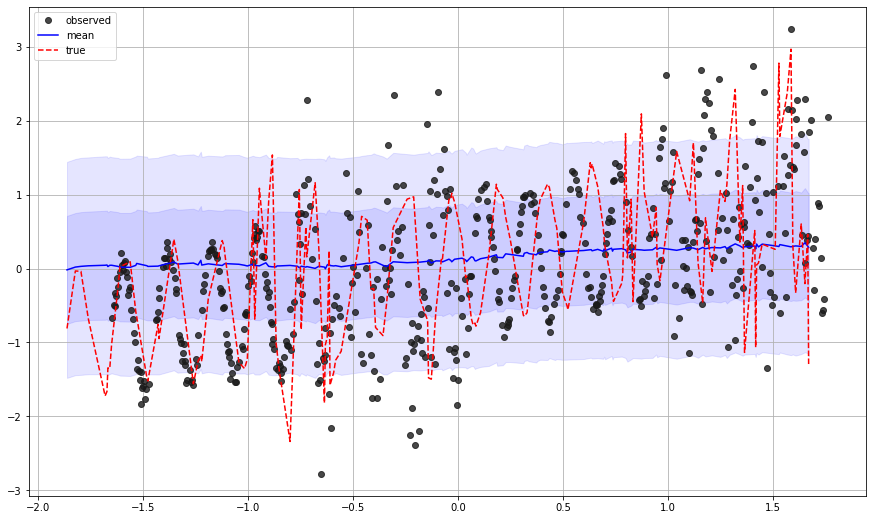

In [226]:
X, y = X_h_c, y_h_c


X['train'], y['train'] = zip(*sorted(zip(X['train'], y['train'])))
X['val'], y['val'] = zip(*sorted(zip(X['val'], y['val'])))
X['test'], y['test'] = zip(*sorted(zip(X['test'], y['test'])))


# x_test = X['test'].reshape(-1).detach().numpy()
# x_obs = X['train'].reshape(-1).detach().numpy()

# y_obs = y['train'].reshape(-1).detach().numpy()
# y_test = y['test'].reshape(-1).detach().numpy()

x_test = np.array(X['test'])
x_obs = np.array(X['train'])

y_obs = np.array(y['train'])
y_test = np.array(y['test'])


def uncertainity_estimate(x, model, num_samples, l2):
    outputs = np.hstack([model(x_num = x, x_cat = None).cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - 0.2) / (2. * N * 1e-5)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std



iters_uncertainty = 100

lengthscale = 0.01
n_std = 2 # number of standard deviations to plot
y_mean, y_std = uncertainity_estimate(torch.Tensor(x_test).view(-1,1).to(device), model, iters_uncertainty, lengthscale)

plt.figure(figsize=(15,9))
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
plt.plot(x_test, y_test, ls='--', color='r', label='true')
for i in range(n_std):
    plt.fill_between( x_test,
        y_mean - y_std * ((i+1.)),
        y_mean + y_std * ((i+1.)),
        color="b",
        alpha=0.1)
plt.legend()
plt.grid()





# Result UE via STD

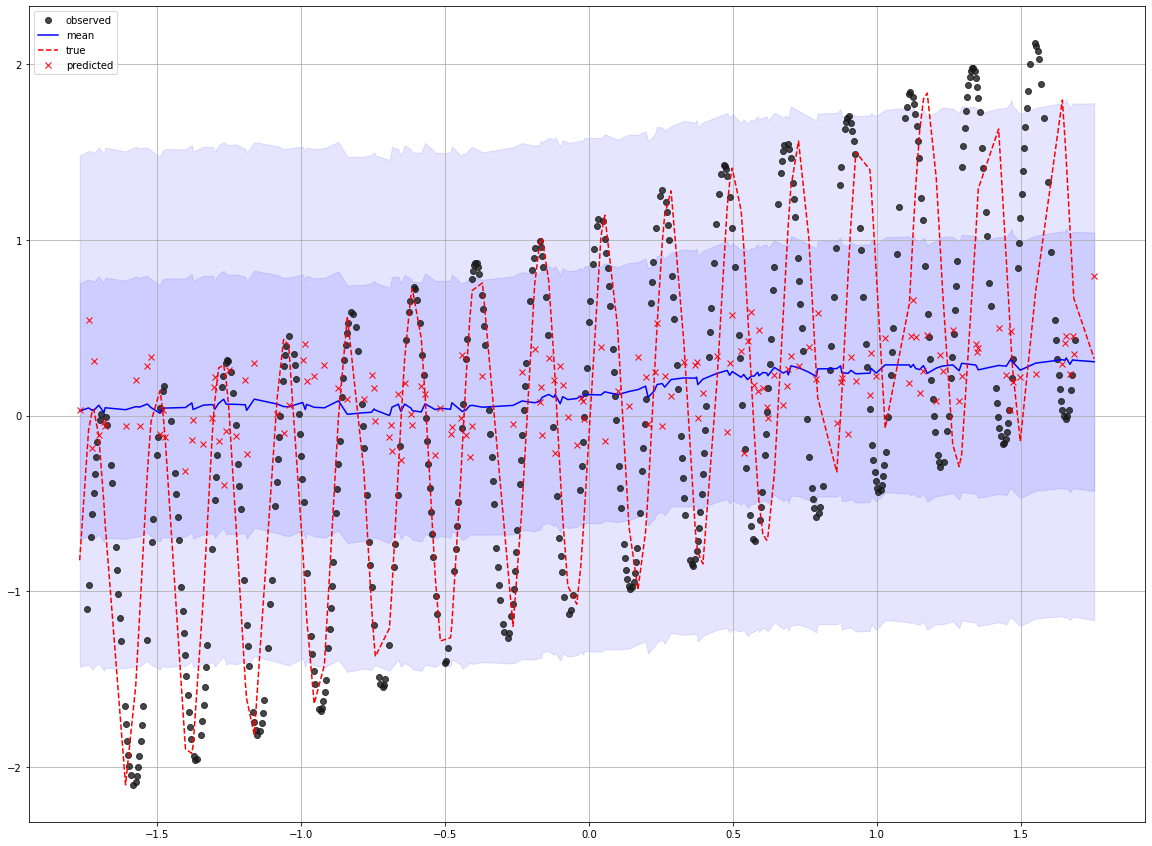

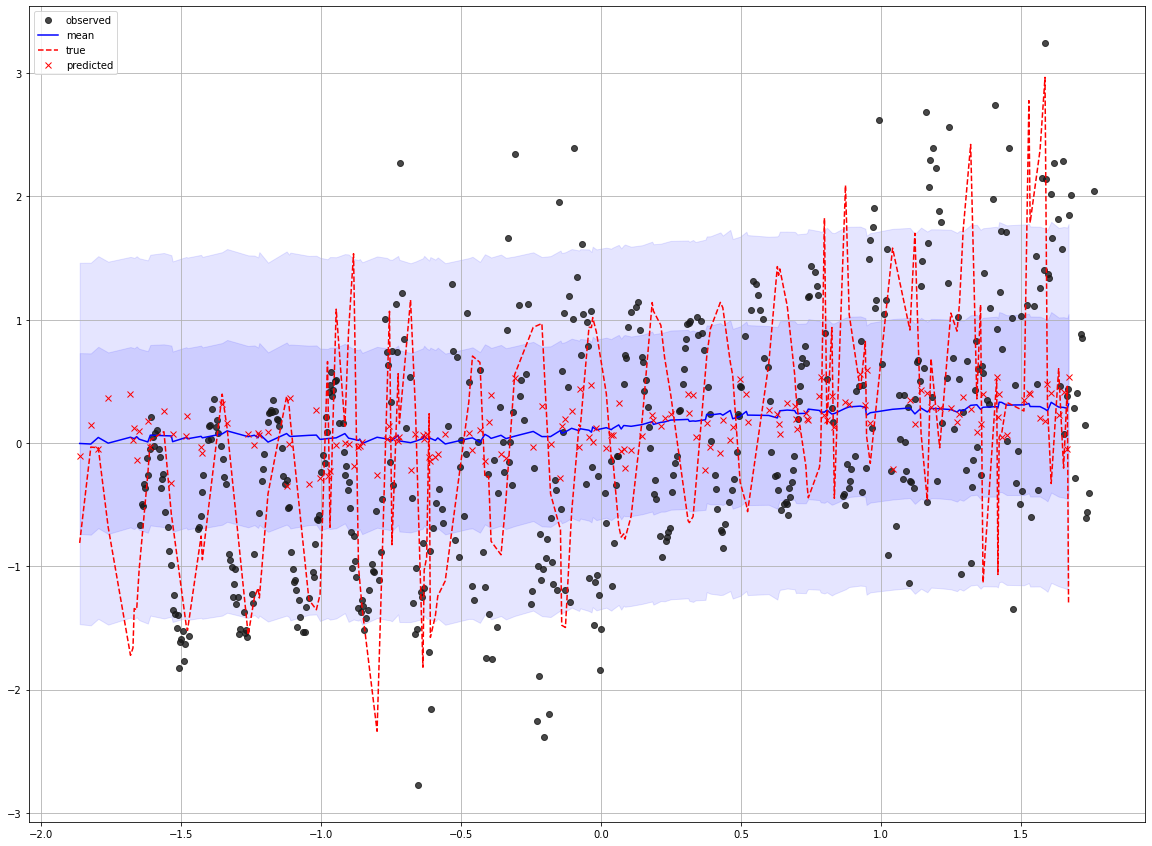

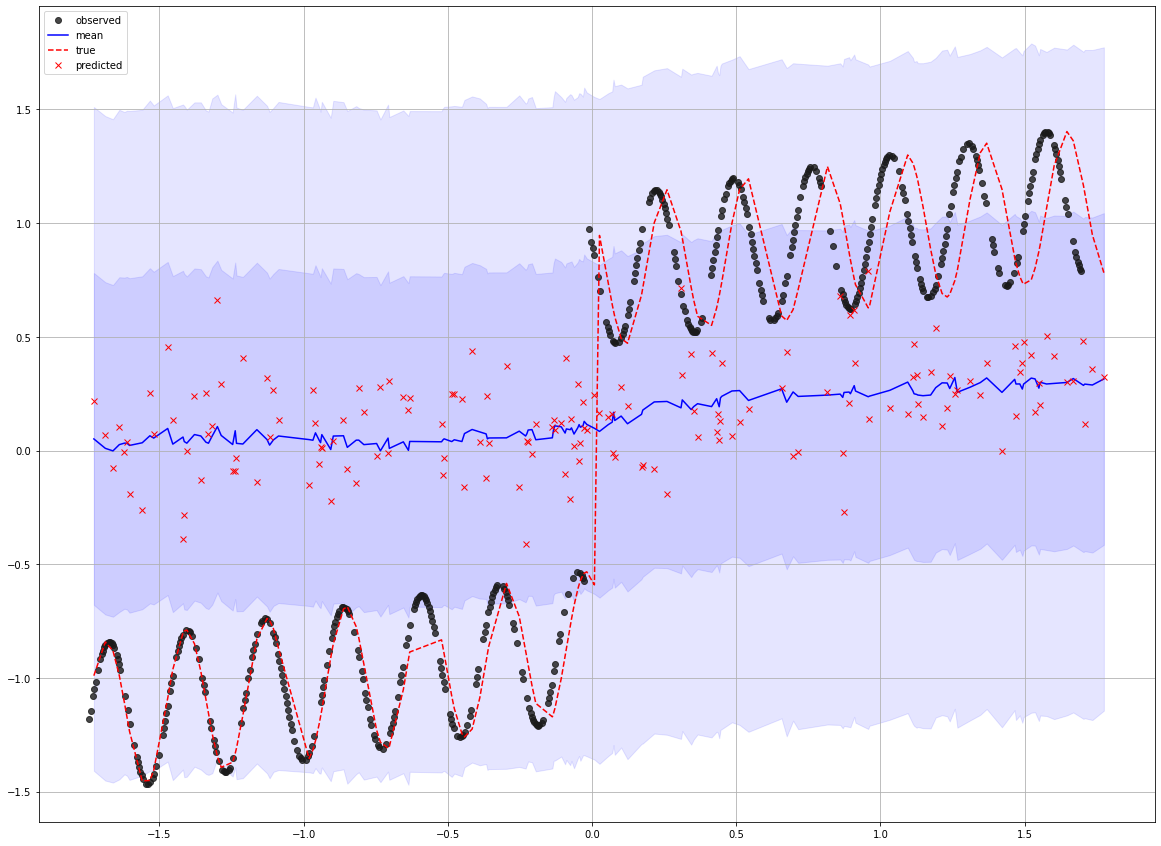

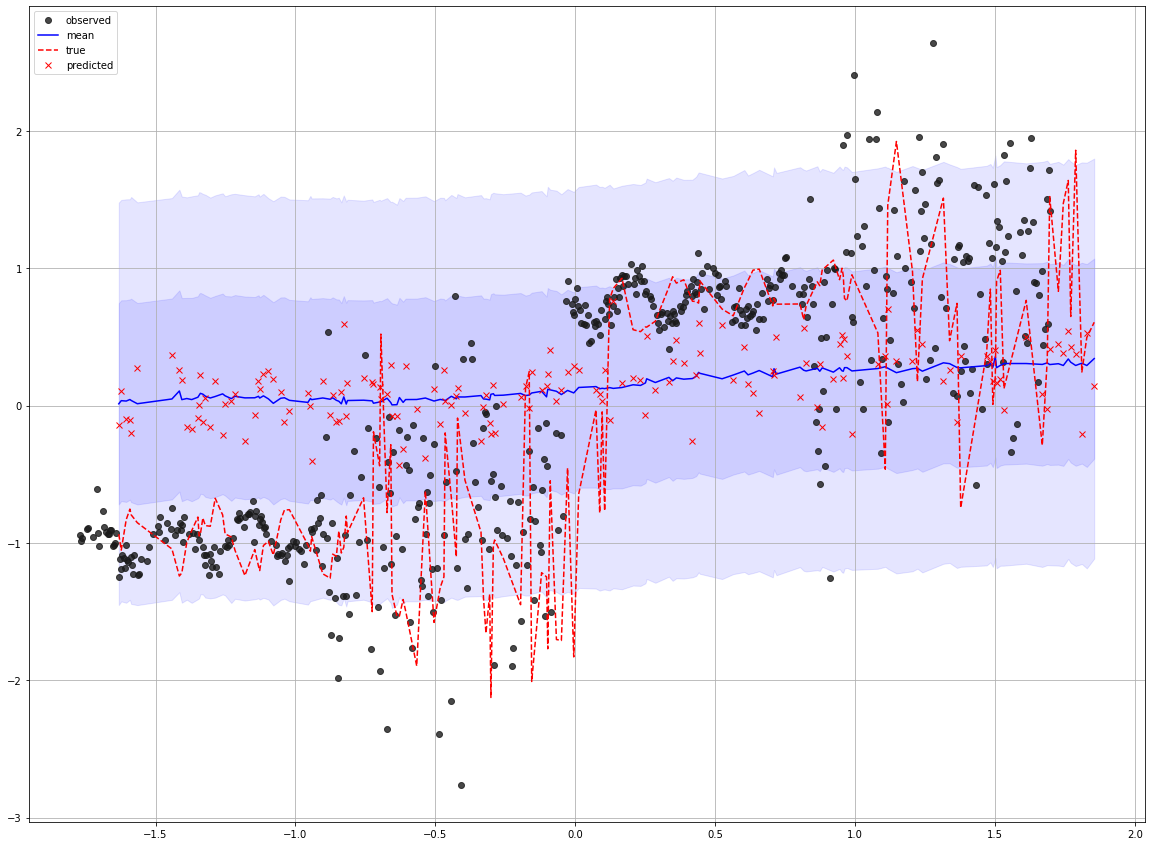

In [246]:
iters_uncertainty = 100
lengthscale = 0.01
n_std = 2 # number of standard deviations to plot

def uncertainity_estimate(x, model, num_samples, l2):
        outputs = np.hstack([model(x_num = x, x_cat = None).cpu().detach().numpy() for i in range(num_samples)]) # n번 inference, output.shape = [20, N]
        y_mean = outputs.mean(axis=1)
        y_variance = outputs.var(axis=1)
        tau = l2 * (1. - 0.2) / (2. * N * 1e-5)
        y_variance += (1. / tau)
        y_std = np.sqrt(y_variance)
        return y_mean, y_std


for (X, y) in [(X_g_c, y_g_c), (X_h_c, y_h_c), (X_g_d, y_g_d), (X_h_d, y_h_d)]:
    
    X['train'], y['train'] = zip(*sorted(zip(X['train'], y['train'])))
    X['val'], y['val'] = zip(*sorted(zip(X['val'], y['val'])))
    X['test'], y['test'] = zip(*sorted(zip(X['test'], y['test'])))

    x_test = np.array(X['test'])
    x_obs = np.array(X['train'])

    y_obs = np.array(y['train'])
    y_test = np.array(y['test'])

    y_mean, y_std = uncertainity_estimate(torch.Tensor(x_test).view(-1,1).to(device), model, iters_uncertainty, lengthscale)

    y_pred = model(x_num = torch.Tensor(X['test']).view(-1,1).to(device), x_cat = None).reshape(-1).detach().numpy()
    
    plt.figure(figsize=(20,15))
    
    plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
    plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
    plt.plot(x_test, y_test, ls='--', color='r', label='true')
    plt.plot(x_test, y_pred,  ls="none", marker="x", color="r", label="predicted")
    
    for i in range(n_std):
        plt.fill_between( x_test,
            y_mean - y_std * ((i+1.)),
            y_mean + y_std * ((i+1.)),
            color="b",
            alpha=0.1)
    
    plt.legend(loc = 2)
    plt.grid()
    




